In [3]:
import sys
sys.path.append('/home/miguelcosta/Desktop/PBL-HGO')
import pandas as pd
# import pandasql as ps
#import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from src.db.connection import *
from src.modelling_pipelines.final_model_pipeline import *
from src.modelling_pipelines.modelling_functions.xgboost import *
alertP1=connection("credentials.txt")
data = pre_process(alertP1)

X = data.Texto
y = data.result # Target variable

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)


Tables: [(bytearray(b'ConsultaUrgencia_doentespedidosconsultaNeurologia2012'),), (bytearray(b'consultaneurologia2012'),), (bytearray(b'consultaneurologia201216anon_true'),), (bytearray(b'hgo_data_032023'),)]
313


/home/miguelcosta/Desktop/PBL-HGO/src/db/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)
/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_model(X_train, y_train, model_name):
    # Convert Series to lists
    X_train = X_train.tolist()
    y_train = y_train.tolist()

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Convert data to tensors
    dataset = TextDataset(X_train, y_train, tokenizer)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1,
        per_device_train_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
    )

    # Train model
    trainer.train()

    return model


2023-10-10 18:07:07.872672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 18:07:07.912009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 18:07:07.912048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 18:07:07.912071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 18:07:07.918881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [31]:
model = train_model(X_train, y_train, "pucpr/biobertpt-all")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pucpr/biobertpt-all and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


KeyboardInterrupt: 

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_pca(embeddings, q):
    # Compute PCA
    _, S, V = torch.pca_lowrank(embeddings, q=q)

    # Compute the projection matrix
    projection_matrix = V[:, :q] / torch.sqrt(S[:q])

    return projection_matrix

def apply_pca(embeddings, projection_matrix):
    # Apply PCA to embeddings
    reduced_embeddings = torch.mm(embeddings, projection_matrix)

    return reduced_embeddings

def train_model_and_pca(X_train, y_train, model_name, q):
    # Convert Series to lists
    X_train = X_train.tolist()
    y_train = y_train.tolist()

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Convert data to tensors
    dataset = TextDataset(X_train, y_train, tokenizer)
    dataloader = DataLoader(dataset, batch_size=64)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Define loss function
    loss_fn = CrossEntropyLoss()

    all_embeddings = []

    # Training loop
    for epoch in range(1):  # Number of epochs
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass and get embeddings
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)

            all_embeddings.append(embeddings.detach())

            # Forward pass through classification head
            logits = model.classifier(embeddings)

            # Compute loss
            loss = loss_fn(logits.view(-1, model.config.num_labels), labels.view(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Concatenate all embeddings
    all_embeddings = torch.cat(all_embeddings, dim=0)

    # Compute PCA on all embeddings and get projection matrix
    projection_matrix = train_pca(all_embeddings, q)

    return model, projection_matrix

def predict_with_pca(model, projection_matrix, X_test, model_name):
    # Convert Series to list
    X_test = X_test.tolist()

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Convert data to tensors
    dataset = TextDataset(X_test, [0]*len(X_test), tokenizer)  # Dummy labels for prediction
    dataloader = DataLoader(dataset, batch_size=64)

    predictions = []

    # Prediction loop
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass and get embeddings
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)

            # Apply PCA to embeddings
            reduced_embeddings = apply_pca(embeddings.detach(), projection_matrix)

            # Forward pass through classification head
            logits = model.classifier(reduced_embeddings)

            # Get predictions
            _, preds = torch.max(logits.view(-1, model.config.num_labels), dim=1)
            predictions.extend(preds.tolist())

    return predictions


In [9]:
model_pca, projection_matrix = train_model_and_pca(X_train, y_train, "pucpr/biobertpt-all", 64)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pucpr/biobertpt-all and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/miguelcosta/.conda/envs/aequitas/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [20]:
projection_matrix.shape

torch.Size([768, 64])

In [19]:
predictions = predict_with_pca(model_pca, projection_matrix, X_test,"pucpr/biobertpt-all")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 768x2)

In [30]:
def train_model_and_pca(X_train, y_train, model_name, q):
    # Convert Series to lists
    X_train = X_train.tolist()
    y_train = y_train.tolist()

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Convert data to tensors
    dataset = TextDataset(X_train, y_train, tokenizer)
    dataloader = DataLoader(dataset, batch_size=64)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Define loss function
    loss_fn = CrossEntropyLoss()

    all_embeddings = []

    # Training loop
    for epoch in range(1):  # Number of epochs
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass and get embeddings
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)

            all_embeddings.append(embeddings.detach())

            # Forward pass through classification head
            logits = model.classifier(embeddings)

            # Compute loss
            loss = loss_fn(logits.view(-1, model.config.num_labels), labels.view(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Concatenate all embeddings
    all_embeddings = torch.cat(all_embeddings, dim=0)

    # Compute PCA on all embeddings and get projection matrix
    projection_matrix = train_pca(all_embeddings, q)

    # Apply PCA to all embeddings
    reduced_embeddings = apply_pca(all_embeddings.detach(), projection_matrix)

    # Create a new classifier
    classifier = torch.nn.Linear(q, model.config.num_labels)

    # Train the new classifier on the reduced embeddings and labels
    optimizer_classifier = AdamW(classifier.parameters(), lr=1e-5)
    
    for epoch in range(1):  # Number of epochs
        for i in range(0, len(reduced_embeddings), 64):  # Assuming batch size is 64
            batch_embeddings = reduced_embeddings[i:i+64]
            batch_labels = torch.tensor(y_train[i:i+64])

            logits_classifier = classifier(batch_embeddings)

            loss_classifier = loss_fn(logits_classifier.view(-1, model.config.num_labels), batch_labels.view(-1))

            optimizer_classifier.zero_grad()
            loss_classifier.backward()
            optimizer_classifier.step()

    return model.base_model, classifier, projection_matrix

def predict_with_pca(base_model, classifier, projection_matrix, X_test, model_name):
    # Convert Series to list
    X_test = X_test.tolist()

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Convert data to tensors
    dataset = TextDataset(X_test, [0]*len(X_test), tokenizer)  # Dummy labels for prediction
    dataloader = DataLoader(dataset, batch_size=16)

    predictions = []

    # Prediction loop
    base_model.eval()
    classifier.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass and get embeddings
            outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)

            # Apply PCA to embeddings
            reduced_embeddings = apply_pca(embeddings.detach(), projection_matrix)

            # Forward pass through classification head
            logits = classifier(reduced_embeddings)

            # Get predictions
            _, preds = torch.max(logits.view(-1, 2), dim=1)
            predictions.extend(preds.tolist())

    return predictions


In [23]:
modelbase, classifier, projection_matrix = train_model_and_pca(X_train, y_train, "pucpr/biobertpt-all", 64)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pucpr/biobertpt-all and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/miguelcosta/.conda/envs/aequitas/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
predictions = predict_with_pca(modelbase, classifier, projection_matrix, X_test,"pucpr/biobertpt-all")


/tmp/ipykernel_202871/1845616457.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predictions, palette='Set2')


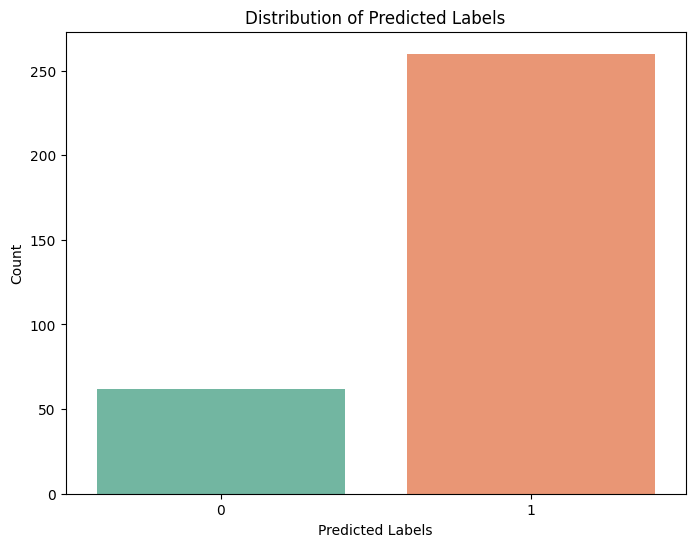

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(x=predictions, palette='Set2')
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()


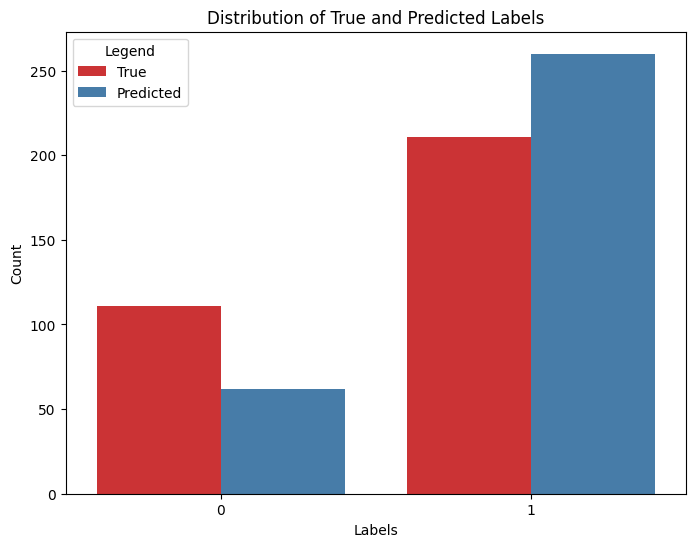

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization
df = pd.DataFrame({'Labels': np.concatenate([y_test, predictions]),
                   'Type': np.repeat(['True', 'Predicted'], len(y_test))})

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Labels', hue='Type', palette='Set1')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of True and Predicted Labels')
plt.legend(title='Legend', labels=['True', 'Predicted'])
plt.show()

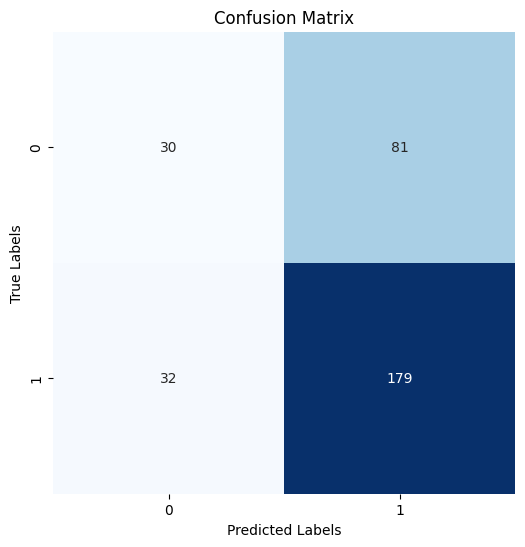

Precision: 0.6884615384615385
Recall: 0.8483412322274881
F1 Score: 0.7600849256900212


In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted labels
# Replace 'y_true' and 'y_pred' with your actual values
y_true = y_test
y_pred = predictions

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("Precision:", precision)
print("Recall:", recall)

from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

print("F1 Score:", f1)

